In [3]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

import torchmetrics

In [ ]:
data_path = 'train'

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(f"Device: {device}")

Device: cuda:0


In [7]:
batch_size = 32

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(0.5),
     transforms.RandomVerticalFlip(0.5),
     transforms.RandomRotation(24),
     transforms.ToTensor(),
     transforms.RandomErasing(0.4),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
dataset = ImageFolder(data_path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset = ImageFolder(data_path, transform=train_transform)
val_dataset.dataset = ImageFolder(data_path, transform=val_test_transform)
test_dataset.dataset = ImageFolder(data_path, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of images in training dataset: {len(train_dataset)}")
print(f"Number of images in validation dataset: {len(val_dataset)}")
print(f"Number of images in test dataset: {len(test_dataset)}")

Number of images in training dataset: 70408
Number of images in validation dataset: 8801
Number of images in test dataset: 8802


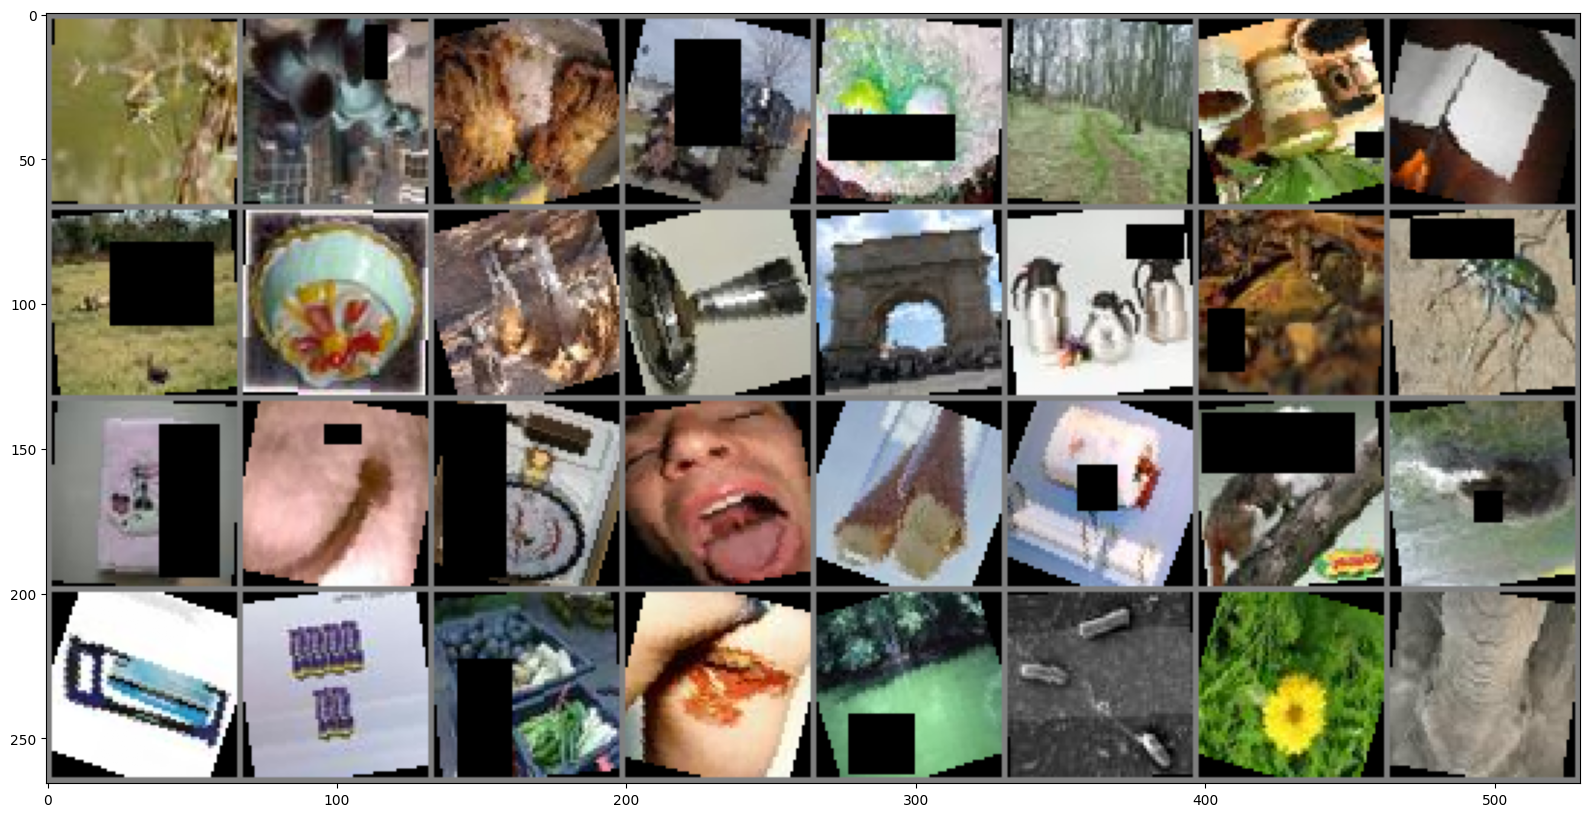

['frog', 'acoustic', 'crab', 'truck', 'egg', 'birch', 'tea', 'towel', 'swine', 'icecream', 'kangaroo', 'spoon', 'memorial', 'pot', 'frog', 'beetle', 'towel', 'worm', 'gauge', 'bacteria', 'icecream', 'towel', 'monkey', 'turtle', 'saw', 'battery', 'squash', 'bacteria', 'bacteria', 'bacteria', 'flower', 'elephant']


In [19]:
plt.figure(figsize = (20,10))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

print(list(dataset.classes[labels[j]] for j in range(batch_size)))

In [9]:
images[0:1].size()

torch.Size([1, 3, 64, 64])

In [10]:
results = pd.DataFrame(columns=['model', 'max_val_acc'])

In [21]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1= nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(6)
        )
        self.conv2= nn.Sequential(
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(16),
        )
        self.conv3= nn.Sequential(
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32)
        )
        self.conv4= nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )

        self.shortcut1_to_3 = nn.Sequential(
            nn.Conv2d(6, 32, kernel_size=1, stride=4),
            nn.BatchNorm2d(32),
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.ReLU()
        )

        self.shortcut2_to_4 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=1, stride=4),
            nn.BatchNorm2d(64),
            nn.AdaptiveAvgPool2d((2, 2)),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(64 * 2 * 2, 1024),
            nn.ReLU(),

            nn.Linear(1024, 256),
            nn.ReLU(),

            nn.Linear(256, 50)
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x3 = x3 + self.shortcut1_to_3(x1)
        x4 = self.conv4(x3)
        x4 = x4 + self.shortcut2_to_4(x2)
        x = torch.flatten(x4, 1)
        x = self.fully_connected(x)
        return x

In [12]:
def evaluate(model, dataloader, device, num_classes):
    model.eval()
    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes).to(device)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        with torch.inference_mode():
            logits = model(X)
            _, preds = torch.max(logits, dim=1)

            metric_acc(preds, y)

    return metric_acc.compute()

In [13]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, device, num_classes, epochs, patience=10):
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    metric_acc = torchmetrics.classification.Accuracy(task='multiclass', num_classes=num_classes).to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            metric_acc(outputs, labels)

            running_loss += loss.item()

        loss = running_loss / 2000
        train_acc = metric_acc.compute()
        val_acc = evaluate(model, val_dataloader, device, num_classes)
        print(f'[{epoch+1}/{epochs}] {loss=:.4f}, {train_acc=:.4f}, {val_acc=:.4f}')

        metric_acc.reset()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            patience_counter = 0

            torch.save(best_model_state, 'best_model.pth')

        else:
            patience_counter += 1


        if patience_counter >= patience:
            break

    model.load_state_dict(best_model_state)
    print('Finished Training')

    return best_val_acc

In [59]:
classifier = ImageClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)

max_val_acc = train(classifier, criterion, optimizer, train_loader, val_loader, device, len(dataset.classes), epochs=100, patience=10)

results = pd.concat([results, pd.DataFrame({'model': [str(classifier)], 'max_val_acc': [max_val_acc.cpu()]})], ignore_index=True)

[1/100] loss=3.3506, train_acc=0.1934, val_acc=0.2446
[2/100] loss=3.0187, train_acc=0.2630, val_acc=0.2894
[3/100] loss=2.8814, train_acc=0.2942, val_acc=0.3229
[4/100] loss=2.7855, train_acc=0.3152, val_acc=0.3398
[5/100] loss=2.7126, train_acc=0.3299, val_acc=0.3551
[6/100] loss=2.6535, train_acc=0.3434, val_acc=0.3785
[7/100] loss=2.5948, train_acc=0.3567, val_acc=0.3858
[8/100] loss=2.5516, train_acc=0.3677, val_acc=0.3938
[9/100] loss=2.5125, train_acc=0.3710, val_acc=0.4031
[10/100] loss=2.4828, train_acc=0.3800, val_acc=0.4017
[11/100] loss=2.4507, train_acc=0.3883, val_acc=0.4120
[12/100] loss=2.4249, train_acc=0.3930, val_acc=0.4129
[13/100] loss=2.4033, train_acc=0.3984, val_acc=0.4176
[14/100] loss=2.3700, train_acc=0.4057, val_acc=0.4205
[15/100] loss=2.3493, train_acc=0.4102, val_acc=0.4200
[16/100] loss=2.3320, train_acc=0.4154, val_acc=0.4277
[17/100] loss=2.3199, train_acc=0.4173, val_acc=0.4355
[18/100] loss=2.2955, train_acc=0.4210, val_acc=0.4379
[19/100] loss=2.280

In [ ]:
test_accuracy = evaluate(classifier, test_loader, device, len(dataset.classes)).item()
print(f'{test_accuracy=:.4f}')

In [58]:
results

,model,max_val_acc
id,,
0,"ImageClassifier( \n (conv1): Conv2d(3, 6, ker...",tensor(0.3114)
1,"ImageClassifier( \n (conv1): Conv2d(3, 6, ker...",tensor(0.3002)
2,"ImageClassifier( \n (conv1): Conv2d(3, 6, ker...",tensor(0.3192)
3,ImageClassifier(\n (convolutional): Sequentia...,tensor(0.3817)
4,ImageClassifier(\n (convolutional): Sequentia...,tensor(0.3690)
5,ImageClassifier(\n (convolutional): Sequentia...,tensor(0.2959)
6,ImageClassifier(\n (convolutional): Sequentia...,tensor(0.3712)
7,ImageClassifier(\n (convolutional): Sequentia...,tensor(0.3906)
8,ImageClassifier(\n (convolutional): Sequentia...,tensor(0.3230)
